In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('restaurant_data.csv')
risks = {'None': 0, 'Moderate Risk': 2, 'Low Risk': 1, 'High Risk': 3}     ###changed 2 to 1 for 'low risk'
health_office = [37.778155, -122.418614]
df['miles_from_inspector'] = (((df.latitude - health_office[0])*69)**2 + ((df.longitude - health_office[1])*55)**2)**.5
df['risk_numeric'] = [risks[c] for c in df.risk_category]
df['time'] = [pd.to_datetime('{}/{}/{}'.format(r[1].day, r[1].month, r[1].year), format='%d/%m/%Y') for r in df.iterrows()]
df.head()

,month,day,year,business_id,risk_category,inspection_score,zipcode,latitude,longitude,miles_from_inspector,risk_numeric,time
0,2,26,2018,10030,None,100,94103,37.766864,-122.419014,0.779390,0,2018-02-26
1,9,5,2017,10083,Moderate Risk,81,94111,37.794024,-122.401299,1.451159,2,2017-09-05
2,9,5,2017,10083,Moderate Risk,81,94111,37.794024,-122.401299,1.451159,2,2017-09-05
3,4,26,2019,10083,Moderate Risk,86,94111,37.794024,-122.401299,1.451159,2,2019-04-26
4,9,19,2017,10280,Moderate Risk,92,94102,37.782034,-122.419777,0.275188,2,2017-09-19


In [3]:
sort = df.sort_values('time')
sort['ind'] = list(range(len(sort)))
sort.head()

inspection_counts = []
most_recent_ind = {}
inspections_between = {}
keys_seen = set()
for i, row in sort.iterrows():
    key = '{}{}'.format(row.business_id, row.time)
    if key not in keys_seen:
        id_ = row.business_id
        if id_ in most_recent_ind:
            between = row.ind - most_recent_ind[id_]
            print(row.ind, most_recent_ind[id_])
            inspections_between[key] = between
            inspection_counts.append(between)
        most_recent_ind[id_] = row.ind
    keys_seen.add(key)
    
df['inspections_since'] = df.apply(lambda row: inspections_between.get('{}{}'.format(row.business_id, row.time), int(np.mean(
    inspection_counts))), axis = 1)
df.head()

277 72
369 332
531 84
547 64
555 170
565 295
570 3
572 38
617 184
634 57
639 140
657 247
667 91
680 28
715 82
728 216
753 129
777 234
787 39
789 95
795 236
797 90
798 92
801 592
806 219
821 324
824 486
825 264
826 291
830 245
831 168
832 201
834 492
836 430
845 63
846 476
848 73
849 193
855 191
867 118
895 594
897 300
898 239
905 500
917 36
930 142
937 114
942 302
952 34
960 411
965 515
973 261
974 50
983 30
986 169
992 66
994 989
998 547
1004 641
1005 572
1014 514
1016 474
1017 107
1018 54
1020 209
1025 473
1035 46
1036 595
1039 485
1041 22
1046 104
1050 316
1053 577
1054 167
1059 294
1061 161
1068 408
1069 1
1073 321
1076 244
1082 231
1090 172
1096 569
1111 218
1115 550
1119 358
1123 274
1127 662
1134 155
1144 137
1147 262
1157 290
1163 213
1165 640
1172 206
1174 273
1180 124
1182 252
1184 121
1191 106
1194 424
1196 448
1214 494
1215 13
1219 182
1220 222
1222 141
1226 548
1227 320
1230 363
1234 379
1239 68
1250 272
1252 607
1257 179
1259 251
1261 108
1267 446
1280 393
1288 319
1289 5

,month,day,year,business_id,risk_category,inspection_score,zipcode,latitude,longitude,miles_from_inspector,risk_numeric,time,inspections_since
0,2,26,2018,10030,None,100,94103,37.766864,-122.419014,0.779390,0,2018-02-26,1141
1,9,5,2017,10083,Moderate Risk,81,94111,37.794024,-122.401299,1.451159,2,2017-09-05,1141
2,9,5,2017,10083,Moderate Risk,81,94111,37.794024,-122.401299,1.451159,2,2017-09-05,1141
3,4,26,2019,10083,Moderate Risk,86,94111,37.794024,-122.401299,1.451159,2,2019-04-26,1882
4,9,19,2017,10280,Moderate Risk,92,94102,37.782034,-122.419777,0.275188,2,2017-09-19,1141


In [4]:
'''
df['time_since'] = -1
for b in df.business_id.unique():
    dfb = df[df.business_id == b].sort_values('time', ascending =False)
    if len(dfb.time.unique()) > 1:
        last = max(dfb.time)
        prev = max([t for t in dfb.time if t < last])
        ind = dfb.index[0]
        since = last - prev
        df.loc[ind,'time_since'] = int(since.days)
'''

times = []
key_to_avg_time_between_mapping = {}     #maps time-business_id keys to the average time between all prior inspections
key_to_time_until = {}
for b in df.business_id.unique():
    dfb = df[df.business_id == b].sort_values('time', ascending = True)
    old_time = -1
    old_key = -1
    times_for_this_business = []
    for i, row in dfb.iterrows():
        time = row.time
        key = '{}{}'.format(row.business_id, row.time)
        if old_time == -1:
            key_to_avg_time_between_mapping[key] = None
        elif time != old_time:
            time_diff = np.abs(int((time - old_time).days))
            times.append(time_diff)
            times_for_this_business.append(time_diff)
            key_to_avg_time_between_mapping[key] = int(np.floor(np.mean(times_for_this_business)))
            key_to_time_until[old_key] = time_diff     
        old_time = time
        old_key = key

In [5]:
mean_time_diff = int(np.floor(np.mean(times)))
for i in key_to_avg_time_between_mapping:
    if key_to_avg_time_between_mapping[i] == None:
        key_to_avg_time_between_mapping[i] = mean_time_diff
        
mean_time_diff

388

In [6]:
#df = df.replace(-1,df[(df.time_since != -1) & (df.year != 2019)].time_since.mean())

df['time_since'] = df.apply(lambda row: key_to_avg_time_between_mapping['{}{}'.format(row.business_id, row.time)], axis = 1)
df['time_until'] = df.apply(lambda row: key_to_time_until.get('{}{}'.format(row.business_id, row.time), -1), axis = 1)

In [7]:
df.head(50)

,month,day,year,business_id,risk_category,inspection_score,zipcode,latitude,longitude,miles_from_inspector,risk_numeric,time,inspections_since,time_since,time_until
0,2,26,2018,10030,None,100,94103,37.766864,-122.419014,0.779390,0,2018-02-26,1141,388,-1
1,9,5,2017,10083,Moderate Risk,81,94111,37.794024,-122.401299,1.451159,2,2017-09-05,1141,388,598
2,9,5,2017,10083,Moderate Risk,81,94111,37.794024,-122.401299,1.451159,2,2017-09-05,1141,388,598
3,4,26,2019,10083,Moderate Risk,86,94111,37.794024,-122.401299,1.451159,2,2019-04-26,1882,598,-1
4,9,19,2017,10280,Moderate Risk,92,94102,37.782034,-122.419777,0.275188,2,2017-09-19,1141,388,198
5,4,5,2018,10280,Low Risk,88,94102,37.782034,-122.419777,0.275188,1,2018-04-05,732,198,196
6,10,18,2018,10280,High Risk,81,94102,37.782034,-122.419777,0.275188,3,2018-10-18,514,197,134
7,10,18,2018,10280,Low Risk,81,94102,37.782034,-122.419777,0.275188,1,2018-10-18,514,197,134
8,10,18,2018,10280,Low Risk,81,94102,37.782034,-122.419777,0.275188,1,2018-10-18,514,197,134
9,10,18,2018,10280,Low Risk,81,94102,37.782034,-122.419777,0.275188,1,2018-10-18,514,197,134


In [9]:
X = df[df.year != 2019]
X = df[['time', 'business_id', 'risk_numeric', 'inspection_score', 'miles_from_inspector', 'inspections_since', 'time_since', 'time_until']]
max_times = {}
for i, row in X.iterrows():
    if row.business_id in max_times:
        max_times[row.business_id] = max([max_times[row.business_id], row.time])
    else:
        max_times[row.business_id] = row.time
X = X[X.time < X.apply(lambda row:max_times[row.business_id], axis=1)]

In [10]:
X.head()

,time,business_id,risk_numeric,inspection_score,miles_from_inspector,inspections_since,time_since,time_until
1,2017-09-05,10083,2,81,1.451159,1141,388,598
2,2017-09-05,10083,2,81,1.451159,1141,388,598
4,2017-09-19,10280,2,92,0.275188,1141,388,198
5,2018-04-05,10280,1,88,0.275188,732,198,196
6,2018-10-18,10280,3,81,0.275188,514,197,134


In [11]:
max_risk = {}
counts = {}
for i, row in X.iterrows():
    key = '{}{}'.format(row.business_id, row.time)
    counts[key] = counts.get(key, 0) + 1
    if key in max_risk:
        max_risk[key] = max([max_risk[key], row.risk_numeric])
    else:
        max_risk[key] = row.risk_numeric

In [12]:
mask = []
seen = set()
for i, row in X.iterrows():
    key = '{}{}'.format(row.business_id, row.time)
    if key not in seen:
        mask.append(True)
        seen.add(key)
    else:
        mask.append(False)

In [13]:
X = X[mask]

for i, row in X.iterrows():
    key = '{}{}'.format(row.business_id, row.time)
    row.risk_numeric = max_risk[key]
    
X['violation_total'] = X.apply(lambda row: counts['{}{}'.format(row.business_id, row.time)], axis = 1)

In [14]:
X

,time,business_id,risk_numeric,inspection_score,miles_from_inspector,inspections_since,time_since,time_until,violation_total
1,2017-09-05,10083,2,81,1.451159,1141,388,598,2
4,2017-09-19,10280,2,92,0.275188,1141,388,198,1
5,2018-04-05,10280,1,88,0.275188,732,198,196,1
6,2018-10-18,10280,3,81,0.275188,514,197,134,4
12,2017-05-23,10282,3,91,1.676005,1141,388,385,1
15,2017-10-02,10332,2,79,0.400260,1141,388,421,3
18,2018-11-27,10332,1,75,0.400260,1262,421,231,3
23,2017-07-28,10433,1,86,0.844765,1141,388,545,1
30,2017-06-05,10540,1,72,1.803992,1141,388,375,6
36,2018-06-15,10540,3,87,1.803992,1239,375,279,1


In [15]:
y = X.time_until
y

1       598
4       198
5       196
6       134
12      385
15      421
18      231
23      545
30      375
36      279
38      372
42      336
45      538
50      320
52      365
55      610
60      539
66      484
71      409
74      741
77      223
80      493
87      610
89      131
90      116
91      530
93      714
99      368
106     526
109     504
       ... 
3105    546
3114    287
3116    324
3118    293
3120    620
3126    294
3127    212
3131    260
3133    287
3135    403
3141    209
3146    612
3150    320
3155    377
3163    322
3164    404
3171    383
3180    366
3181    560
3184    360
3186    533
3189    399
3193    308
3197    290
3200    456
3204    960
3206    448
3208    434
3211    434
3212    191
Name: time_until, Length: 957, dtype: int64

In [16]:
X_features = X[[i for i in X.columns if i not in ['time_until', 'time', 'business_id']]]
X_features['intercept'] = 1

C:\Users\hmoor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
X_features

,risk_numeric,inspection_score,miles_from_inspector,inspections_since,time_since,violation_total,intercept
1,2,81,1.451159,1141,388,2,1
4,2,92,0.275188,1141,388,1,1
5,1,88,0.275188,732,198,1,1
6,3,81,0.275188,514,197,4,1
12,3,91,1.676005,1141,388,1,1
15,2,79,0.400260,1141,388,3,1
18,1,75,0.400260,1262,421,3,1
23,1,86,0.844765,1141,388,1,1
30,1,72,1.803992,1141,388,6,1
36,3,87,1.803992,1239,375,1,1


In [18]:
beta = np.dot(np.dot(np.linalg.inv(np.dot(X_features.T, X_features)), X_features.T), y)

In [19]:
X_shuffle = X.sample(frac=1, random_state=123).reset_index(drop=True)
X_shuffle['intercept'] = 1
subsets = np.array_split(X_shuffle, 10)
all_resid = []
all_pred = []

for i in range(10):
    hold_out = subsets[i]
    train = pd.concat(subsets[0:i] + subsets[i+1:10])
    y = train.time_until
    X_features = train[[i for i in train.columns if i not in ['time_until', 'time', 'business_id']]]
    beta = np.dot(np.dot(np.linalg.inv(np.dot(X_features.T, X_features)), X_features.T), y)
    
    pred = np.dot(hold_out[[i for i in train.columns if i not in ['time_until', 'time', 'business_id']]], beta)
    resid = pred - hold_out.time_until
    all_pred.extend(pred)
    all_resid.extend(list(resid))
    
interval_size = pd.Series(all_resid).quantile(.95)
interval_size

225.49887813602663

In [20]:
cutoff

NameError: name 'cutoff' is not defined

In [83]:
pd.concat(subsets)

,time,business_id,risk_numeric,inspection_score,miles_from_inspector,time_since,time_until,violation_total
0,2016-10-06,33911,3,68,2.336897,388,461,4
1,2017-03-16,68615,2,73,1.716035,388,312,2
2,2017-02-01,59838,1,94,1.046170,388,537,1
3,2017-09-05,10083,2,81,1.451159,388,598,2
4,2017-05-03,32738,1,92,3.167822,388,393,2
...,...,...,...,...,...,...,...,...
952,2016-11-21,59599,1,94,0.725483,388,283,1
953,2016-12-21,25301,2,81,1.043386,388,393,1
954,2019-03-08,36571,1,85,4.119542,287,196,3
955,2017-05-18,61563,2,89,1.250148,388,806,1


In [ ]:
plt.hist([i.month for i in X.time])

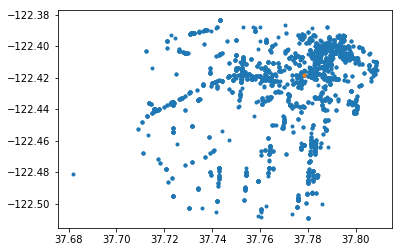

In [21]:
plt.plot(df.latitude, df.longitude, '.')
plt.plot([37.778155], [-122.418614], '.')

In [74]:
for r in range(4):
    filt = X_features[X_features.risk_numeric == r]
    print(filt.inspection_score.mean())

98.20930232558139
87.74245939675174
85.59654178674351
80.38970588235294
